# Importação de bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score,silhouette_score
import xgboost as xgb
from sklearn.cluster import DBSCAN, AgglomerativeClustering
import os
import requests
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
from sklearn.preprocessing import LabelEncoder,StandardScaler


# Funções auxiliares

Função para remoção de outliers

In [5]:
# Tratamento de outliers usando o método do IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

Funções para: 1. Download de txt ; 2. Download, descompactação e armazenamento de .zip

In [6]:

def baixar_arquivo_txt(url, data_directory, nome_arquivo):
    os.makedirs(data_directory, exist_ok=True)
    resposta = requests.get(url)
    caminho_arquivo = os.path.join(data_directory, nome_arquivo)
    with open(caminho_arquivo, 'wb') as f:
        f.write(resposta.content)

def download_and_unzip(url, data_directory, nome_arquivo):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    caminho_arquivo = os.path.join(data_directory, nome_arquivo)
    zipfile.extractall(path=caminho_arquivo)

# Leitura dos dados

## Importação dos dados necessários direto da URL indicada

'Inclua no seu trabalho o comando para baixar esses dois conjuntos de dados e guardá-los em memória.'

In [7]:
# Importando arquivo de descrição do dataset. Baixando o arquivo zip com os dados e descompactando-o em 'data/'
downloadFlag = False
links = [
    'https://files.grouplens.org/datasets/movielens/ml-1m.zip',
    'https://files.grouplens.org/datasets/movielens/ml-1m-README.txt'
]
nomes_arquivos = ['', 'ml-1m-README.txt']
directory = 'data'

if downloadFlag:
    print("Baixando arquivo de descrição do dataset e o arquivo zip com os dados...")
    baixar_arquivo_txt(links[1], data_directory = directory, nome_arquivo = nomes_arquivos[1])

    download_and_unzip(links[0], data_directory = directory, nome_arquivo = nomes_arquivos[0])

## Leitura dos dados necessários

Foi indicado que apenas seriam usados: 1. 'u.data' ; 2. 'u.item'

In [8]:
movies_df = pd.read_csv(
    os.path.join(directory, 'ml-1m', 'movies.dat'),
    sep='::',
    engine='python',
    names=['MovieID', 'Title', 'Genres'],
    encoding='latin-1'
)

In [9]:
movies_df

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [10]:
ratings_df = pd.read_csv(
    os.path.join(directory, 'ml-1m', 'ratings.dat'),
    sep='::',
    engine='python',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp']
)

In [11]:
ratings_df

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


## Feature Engeneering 1: Separação de gêneros para melhor manipulação (e codificação)

Após testes, percebeu-se que essa estratégia requer muita memória para conseguir rodar o DBSCAN (Sem ou com PCA). Considera-se um outro DF codificando com LabelEncoder

In [12]:
genres_list = [
    'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
    'Sci-Fi', 'Thriller', 'War', 'Western'
]

movies_df_encoded = movies_df.copy()
for genre in genres_list:
    movies_df_encoded[genre] = movies_df_encoded['Genres'].apply(lambda x: int(genre in x))
movies_df_encoded.drop('Genres', axis = 1, inplace=True)

# Análise exploratória dos dados

Verificar numero de filmes, usuários e avaliações

In [13]:
print("Número de filmes:", movies_df['MovieID'].nunique())
print("Número de usuários:", ratings_df['UserID'].nunique())
print("Número de avaliações:", ratings_df['Rating'].count())

Número de filmes: 3883
Número de usuários: 6040
Número de avaliações: 1000209


Gráficos para visualização estatística de avaliações por nota / filmes por gênero / filmes por ano

/tmp/ipykernel_2948/1309876391.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=ratings_df, palette='viridis')
/tmp/ipykernel_2948/1309876391.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='mako')


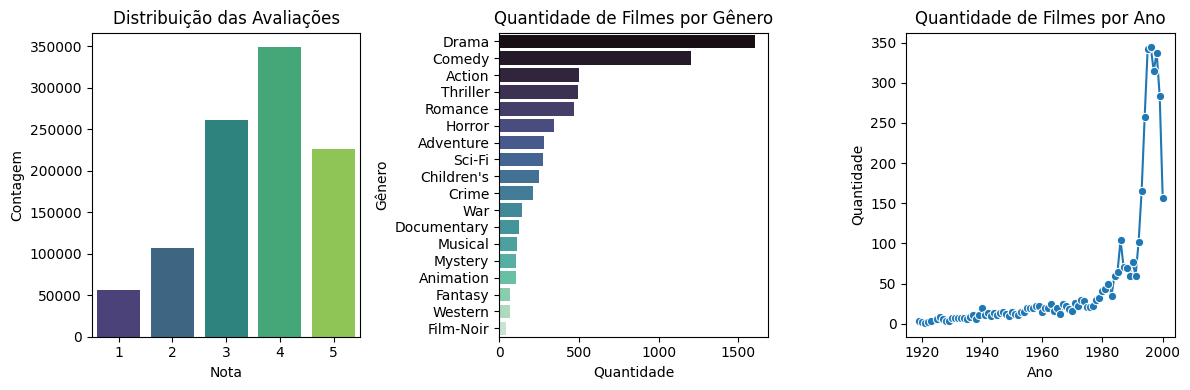

In [14]:
# Distribuição das avaliações por nota
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.countplot(x='Rating', data=ratings_df, palette='viridis')
plt.title('Distribuição das Avaliações')
plt.xlabel('Nota')
plt.ylabel('Contagem')

# Distribuição dos gêneros
plt.subplot(1, 3, 2)
genre_counts = movies_df_encoded[genres_list].sum().sort_values(ascending=False)
sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='mako')
plt.title('Quantidade de Filmes por Gênero')
plt.xlabel('Quantidade')
plt.ylabel('Gênero')

# Quantidade de filmes por ano
plt.subplot(1, 3, 3)
movies_df_encoded['Year'] = movies_df_encoded['Title'].str.extract(r'\((\d{4})\)').astype(float)
year_counts = movies_df_encoded['Year'].value_counts().sort_index()
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')

plt.tight_layout()
plt.show()

Gráficos de avaliações por gênero:
1. Por número de avaliações, que se mostra proporcional ao número de filmes do gênero.
2. Por nota média das avaliações, que mostra pequenas variações na médiia para um gênero ou outro, nada muito discrepante.

/tmp/ipykernel_2948/605424441.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_ratings_count.keys()), y=list(genre_ratings_count.values()), palette='viridis')
/tmp/ipykernel_2948/605424441.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_ratings_mean.keys()), y=list(genre_ratings_mean.values()), palette='mako')


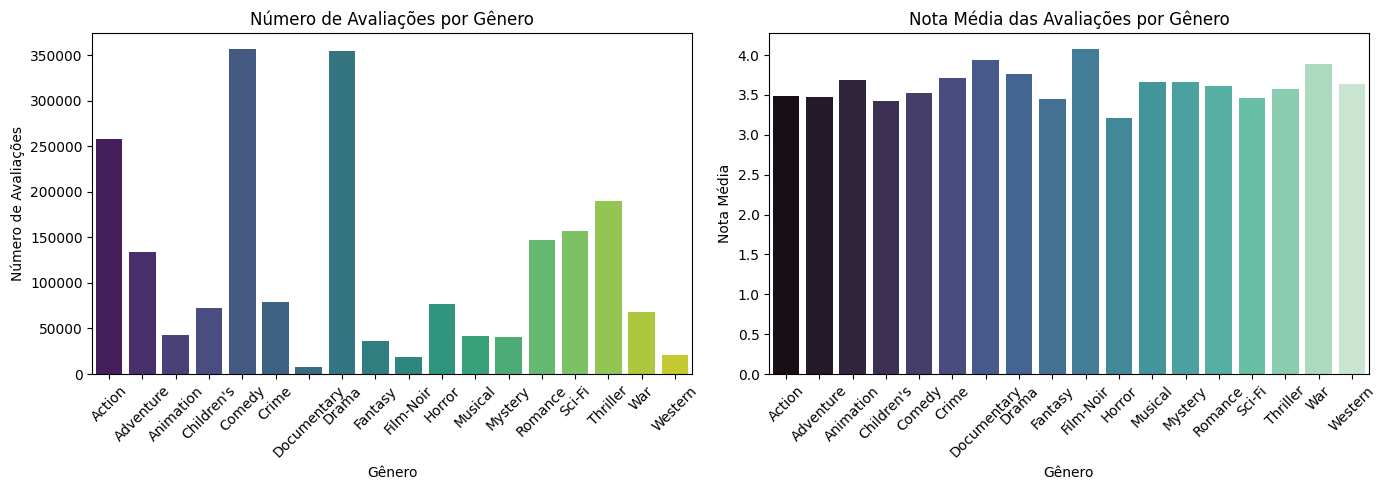

In [15]:
# 1. Número de avaliações por gênero
genre_ratings_count = {}
for genre in genres_list:
    # Seleciona os MovieIDs dos filmes desse gênero
    movie_ids = movies_df_encoded[movies_df_encoded[genre] == 1]['MovieID']
    # Conta quantas avaliações existem para esses filmes
    count = ratings_df[ratings_df['MovieID'].isin(movie_ids)].shape[0]
    genre_ratings_count[genre] = count

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(genre_ratings_count.keys()), y=list(genre_ratings_count.values()), palette='viridis')
plt.title('Número de Avaliações por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Número de Avaliações')
plt.xticks(rotation=45)

# 2. Nota média das avaliações por gênero
genre_ratings_mean = {}
for genre in genres_list:
    movie_ids = movies_df_encoded[movies_df_encoded[genre] == 1]['MovieID']
    mean = ratings_df[ratings_df['MovieID'].isin(movie_ids)]['Rating'].mean()
    genre_ratings_mean[genre] = mean

plt.subplot(1, 2, 2)
sns.barplot(x=list(genre_ratings_mean.keys()), y=list(genre_ratings_mean.values()), palette='mako')
plt.title('Nota Média das Avaliações por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Nota Média')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Pré-processamento

## Duplicatas

Para verificação de duplicatas, usa-se MovieID para os filmes, e 'userID' junto com 'MovieID' para as avaliações.

In [16]:
# Verificando valores duplicados nos principais dataframes
print("Duplicados em ratings_df:", ratings_df.duplicated(subset=['UserID', 'MovieID'], keep=False).sum())
print("Duplicados em movies_df:", movies_df_encoded.duplicated(subset=['MovieID']).sum())

Duplicados em ratings_df: 0
Duplicados em movies_df: 0


## Feature Engineering 2: Separação de timestamp em 'bins' para o dataSet de avaliações

Criação de 10 períodos históricos e de coluna indicando o período de cada avaliação

In [17]:
ratings_df['Date'] = pd.to_datetime(ratings_df['Timestamp'], unit='s').sort_values(ascending=True)

In [18]:
# Criando bins diretamente a partir da coluna 'Date' em ratings_df, usando inteiros de 1 a 10 como labels
date_bins = pd.cut(
    ratings_df['Date'],
    bins=10,
    labels=range(1, 11)
)
ratings_df['Date_Period'] = date_bins.astype(int)
ratings_df.drop(inplace=True, columns=['Date'])

In [19]:
ratings_df_encoded = ratings_df.copy().drop(columns=['Timestamp'])

## Feature Engineering 3: Extrair informação da data de lançamento do filme para o dataSet de filmes

In [20]:
movies_df_encoded['Year'] = movies_df_encoded['Title'].str.extract(r'\((\d{4})\)').astype(int)

In [21]:
le = LabelEncoder()
movies_df_encoded['Year_Label'] = le.fit_transform(movies_df_encoded['Year'])

## Transformar colunas de identificação em index

In [22]:
ratings_df_encoded

,UserID,MovieID,Rating,Date_Period
0,1,1193,5,3
1,1,661,3,3
2,1,914,3,3
3,1,3408,4,3
4,1,2355,5,3
...,...,...,...,...
1000204,6040,1091,1,1
1000205,6040,1094,5,1
1000206,6040,562,5,1
1000207,6040,1096,4,1


In [23]:
movies_df_encoded.index = movies_df_encoded['MovieID']

## Juntar informações (Agregra informações do filme às avaliações)

In [24]:
ratings_df_final = ratings_df_encoded.merge(movies_df_encoded, left_on='MovieID', right_index=True, how='left')
ratings_df_final.drop(columns=['MovieID_x', 'MovieID_y', 'Title','Year'], inplace=True)
ratings_df_final.rename(columns={'Date_Period': 'Review_Date_Period' , 'Year_Label': 'Production_Year_Label'}, inplace=True)

In [25]:
ratings_df_final

,MovieID,UserID,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,1193,1,5,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,55
1,661,1,3,3,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,76
2,914,1,3,3,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,44
3,3408,1,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,80
4,2355,1,5,3,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,1091,6040,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,69
1000205,1094,6040,5,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,72
1000206,562,6040,5,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,75
1000207,1096,6040,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62


Aplicar aleatoriedade na ordem dos dados, a fim de posteriormente dividir os dados sem tedências

In [26]:
ratings_df_final = ratings_df_final.sample(frac=1, random_state=42).reset_index(drop=True)

## Normalização dos dados

Para que algorítimos de clusterização não dê mais significância para uma variável do que outra, é importante normalizar.

In [27]:
# Normalização do ratings_df_final
cols_to_normalize = ratings_df_final.columns.difference(['MovieID', 'UserID'])
scaler = StandardScaler()
ratings_df_final[cols_to_normalize] = scaler.fit_transform(ratings_df_final[cols_to_normalize])

In [28]:
ratings_df_final

,MovieID,UserID,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,2683,5412,-1.415775,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1,904,5440,1.269747,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,4.888194,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-2.279046
2,3717,368,0.374573,0.475069,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,3.40217,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.927070
3,1721,425,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,0.717975
4,3697,4942,-2.310949,-0.950503,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,2.067157,-0.271205,-0.145311,0.230088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,1077,1586,1.269747,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,-0.483756,-0.271205,-0.145311,-0.954781
1000205,2700,2129,1.269747,-0.237717,-0.588749,-0.393236,4.701409,-0.278899,1.343505,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1000206,3102,854,-0.520601,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-0.118403
1000207,3479,4033,1.269747,-0.950503,-0.588749,2.543003,-0.212702,-0.278899,-0.744322,-0.29393,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,-0.118403


## Criação de um DF separado sem variáveis de identificação : ['MovieID', 'UserID']

In [29]:
ratings_train_df = ratings_df_final.drop(columns=['MovieID', 'UserID']).copy()

## Redução de dimensionalidade com PCA

Teste do PCA e plot de 'importância'/variância explicada das componentes

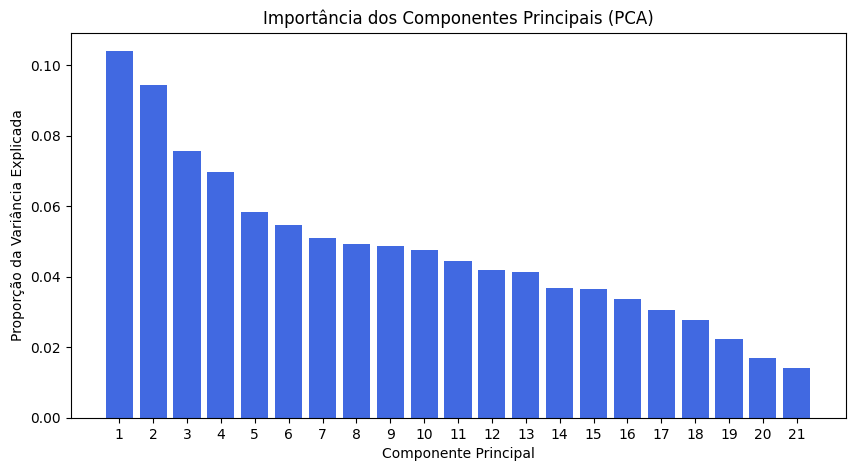

In [30]:
# Executando PCA
pca = PCA()
pca.fit(ratings_train_df)

# Plotando a importância (variância explicada) de cada componente
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='royalblue')
plt.xlabel('Componente Principal')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Importância dos Componentes Principais (PCA)')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

O gráfico de 'variância' das componentes principais dá a entender que selecionar poucas componentes pode ocasionar perda na variância dos dados, fazendo com que se perca informação. Foram realizados testes selecionando 3, 5 ou 10 componentes principais, e foi observado que sempre havia perda de informação, prejudicando os modelos de clusterização.

Criação de DF com 'n_comp' componentes principais.

In [31]:
# Reduzindo ratings_train_df para 5 componentes principais com PCA
n_comp = 10
pca = PCA(n_components=n_comp)
ratings_train_df_pca = pca.fit_transform(ratings_train_df)
ratings_train_pca_df = pd.DataFrame(ratings_train_df_pca, columns=[f'PC{i+1}' for i in range(n_comp)])



## Redução de dimensionalidade com SVD

In [32]:
# Reduzindo ratings_train_df para 10 componentes principais com SVD
n_svd_comp = 10
svd = TruncatedSVD(n_components=n_svd_comp, random_state=42)
ratings_train_df_svd = svd.fit_transform(ratings_train_df)
ratings_train_svd_df = pd.DataFrame(ratings_train_df_svd, columns=[f'SVD{i+1}' for i in range(n_svd_comp)])

Plot requisitado dos valores singulares da matriz diagonal da decomposição SVD. 

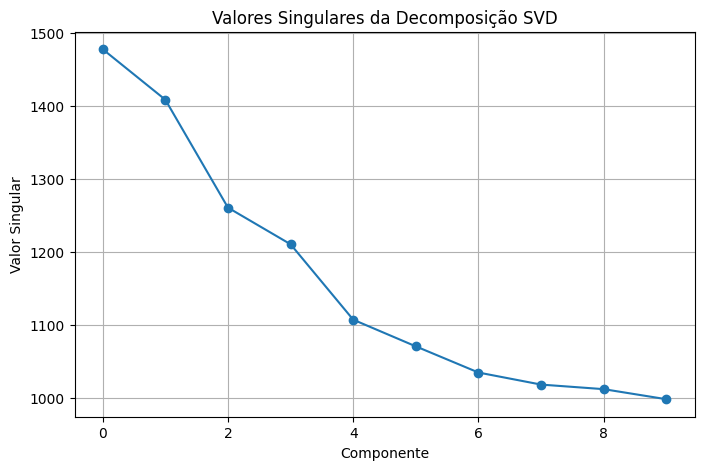

In [33]:
# Plotando os valores singulares (matriz diagonal) da decomposição SVD
plt.figure(figsize=(8, 5))
plt.plot(svd.singular_values_, marker='o')
plt.title('Valores Singulares da Decomposição SVD')
plt.xlabel('Componente')
plt.ylabel('Valor Singular')
plt.grid(True)
plt.show()

## Divisão do dataSet em 10 conjuntos de Sampling (Para rodar no DBSCAN) (sem Redução, PCA e SVD)

In [34]:
# Dividindo ratings_train_df_pca em 10 amostras aproximadamente iguais
ratings_pca_df_dict = {}
ratings_movieid_dict = {}
n_splits = 10
split_size = len(ratings_train_pca_df) // n_splits

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(ratings_train_pca_df)
    ratings_pca_df_dict[i] = ratings_train_pca_df.iloc[start_idx:end_idx].reset_index(drop=True)
    ratings_movieid_dict[i] = ratings_df_final['MovieID'].iloc[start_idx:end_idx].reset_index(drop=True)


In [35]:
ratings_pca_df_dict[0]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.604671,-0.450070,-0.957239,-1.701406,-0.082081,0.247301,0.120725,0.187883,-0.270737,-0.808700
1,-1.076852,-0.437329,3.896776,0.216048,0.824245,1.740655,0.699686,-0.568203,0.616493,-0.299663
2,-1.377915,-0.018774,0.490941,-0.339732,-1.726328,-0.574288,-0.357353,1.434195,-0.560377,-0.193797
3,0.216416,-1.697141,-0.775638,0.641605,-0.744340,-0.178341,0.952825,-0.548616,0.313304,0.494465
4,-2.371272,2.014537,0.043904,-1.159178,0.256372,-1.055245,0.788863,0.482717,-0.232405,-0.492209
...,...,...,...,...,...,...,...,...,...,...
100015,0.963171,-0.941329,-1.199252,-0.853911,0.171306,1.425047,1.705268,0.025107,0.362795,-0.675243
100016,0.851340,-0.620851,-0.379713,-0.594911,0.503704,0.813317,-0.233423,0.097202,0.120757,0.334650
100017,0.701809,-0.219957,0.118232,-1.441030,3.193841,0.300948,-0.289786,-1.412090,-0.635252,-0.670330
100018,0.636048,-1.620691,-0.653197,0.050505,-0.603152,0.025727,-0.620410,-0.014725,-0.024698,0.112807


In [36]:
# Dividindo ratings_train_df em 10 amostras aproximadamente iguais
ratings_df_dict = {}
ratings_movieid_dict2 = {}
n_splits = 10
split_size = len(ratings_train_df) // n_splits

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(ratings_train_df)
    ratings_df_dict[i] = ratings_train_df.iloc[start_idx:end_idx].reset_index(drop=True)
    ratings_movieid_dict2[i] = ratings_df_final['MovieID'].iloc[start_idx:end_idx].reset_index(drop=True)


In [37]:
ratings_df_dict[0]

,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,-1.415775,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1,1.269747,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,4.888194,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-2.279046
2,0.374573,0.475069,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,3.40217,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.927070
3,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,0.717975
4,-2.310949,-0.950503,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,2.067157,-0.271205,-0.145311,0.230088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100015,-0.520601,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,-0.188101
100016,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,-0.606290
100017,-0.520601,-0.237717,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,3.477663,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,-1.860857
100018,1.269747,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372


# Algorítimos de classificação

Definir flag de benchmark

In [41]:
benchmark = True

## K-Médias - Sem PCA

### Benchmark de diversos números de cluster's

Irei primeiro usar o 'Método do cotovelo' para identificar um número bom de clusters. Basicamente, verifica-se em que número de cluster's a distância entre pontos de um mesmo grupo começa a cair menos.


In [42]:
if (benchmark):
    inertia = []
    silhouette_scores = []
    k_range = range(2, 50)  # silhouette_score requires at least 2 clusters

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans_nopca_labels = kmeans.fit_predict(ratings_train_df)
        inertia.append(kmeans.inertia_)
        #score = silhouette_score(ratings_train_df, labels)
        #silhouette_scores.append(score)


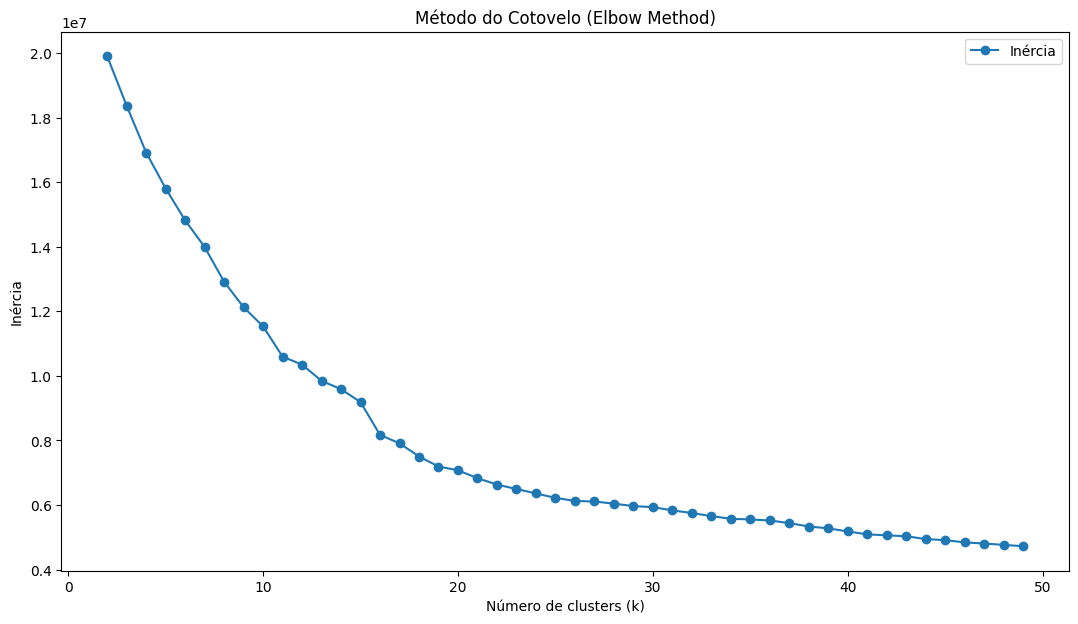

In [43]:
if(benchmark):
    plt.figure(figsize=(13, 7))
    plt.plot(k_range, inertia, marker='o', label='Inércia')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inércia')
    plt.title('Método do Cotovelo (Elbow Method)')
    plt.legend()
    plt.show()

Identifica-se visualmente o cotovelo em torno de 15-30. Estarei selecionando cluster = 25 como padrão 

### Execução do K-Means com 25 cluster's

In [59]:
kmeans_25 = KMeans(n_clusters=25, random_state=42)
kmeans_nopca_25_clusters = kmeans_25.fit_predict(ratings_train_df)

Plot do número de amostras em cada cluster para esse modelo / tipo de processamento.

Total unique labels: 25
Total samples per Split: 1000209


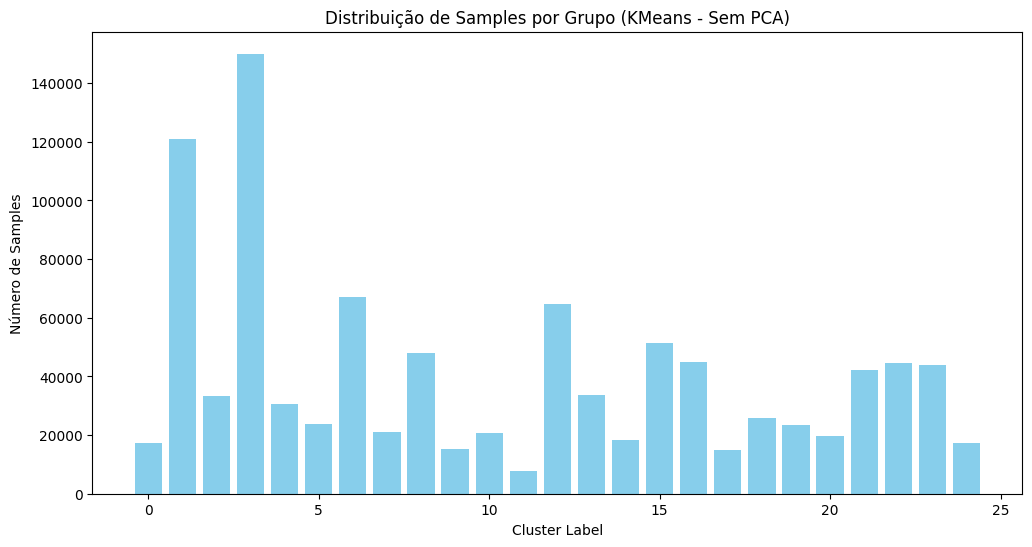

In [60]:
import numpy as np

unique_labels, counts = np.unique(kmeans_nopca_25_clusters, return_counts=True)
print(f"Total unique labels: {len(unique_labels)}")
print(f"Total samples per Split: {len(ratings_train_df)}")

plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (KMeans - Sem PCA)')
plt.show()

Distrbuição com um máximo de 14 % das amostras em um mesmo cluster.

## K-Médias com PCA

### Benchmark de diversos números de cluster's

Irei primeiro usar o 'Método do cotovelo' para identificar um número bom de clusters. Basicamente, verifica-se em que número de cluster's a distância entre pontos de um mesmo grupo começa a cair menos.


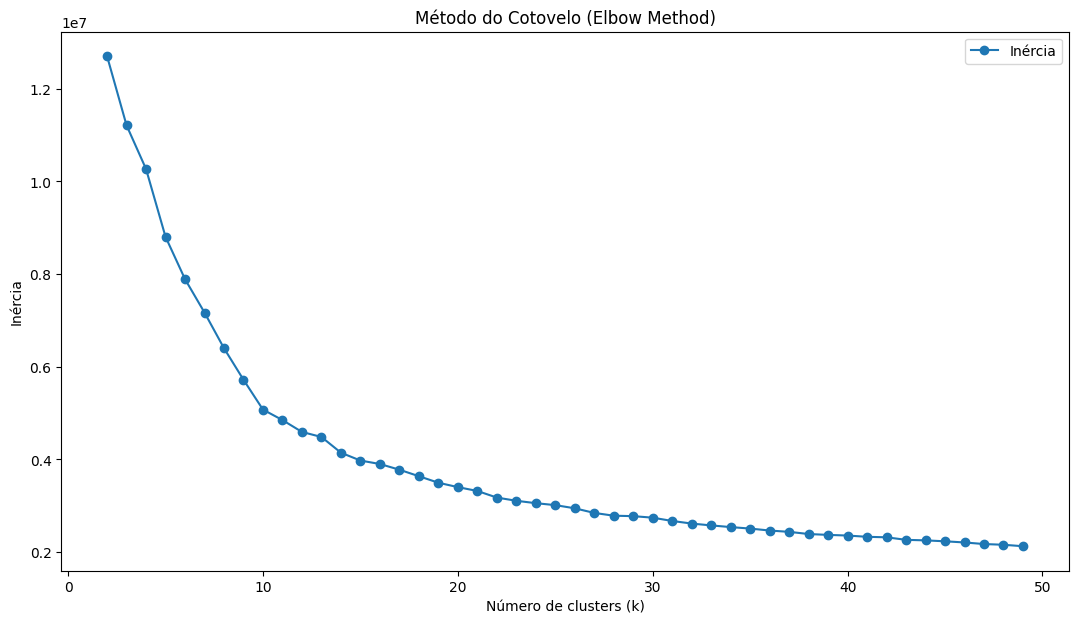

In [44]:
if (benchmark):
    inertia = []
    silhouette_scores = []
    k_range = range(2, 50)  # silhouette_score requires at least 2 clusters

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans_pca_labels = kmeans.fit_predict(ratings_train_pca_df)
        inertia.append(kmeans.inertia_)
        #score = silhouette_score(ratings_train_df, labels)
        #silhouette_scores.append(score)

if(benchmark):
    plt.figure(figsize=(13, 7))
    plt.plot(k_range, inertia, marker='o', label='Inércia')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inércia')
    plt.title('Método do Cotovelo (Elbow Method)')
    plt.legend()
    plt.show()

Resultado bem similar à clusterização sem PCA (usando 10 componentes).

### Execução do K-Means com 25 cluster's

In [61]:
kmeans_25 = KMeans(n_clusters=25, random_state=42)
kmeans_pca_25_clusters = kmeans_25.fit_predict(ratings_train_pca_df)

Plot do número de amostras em cada cluster para esse modelo / tipo de processamento.

Total unique labels: 25
Total samples per Split: 1000209


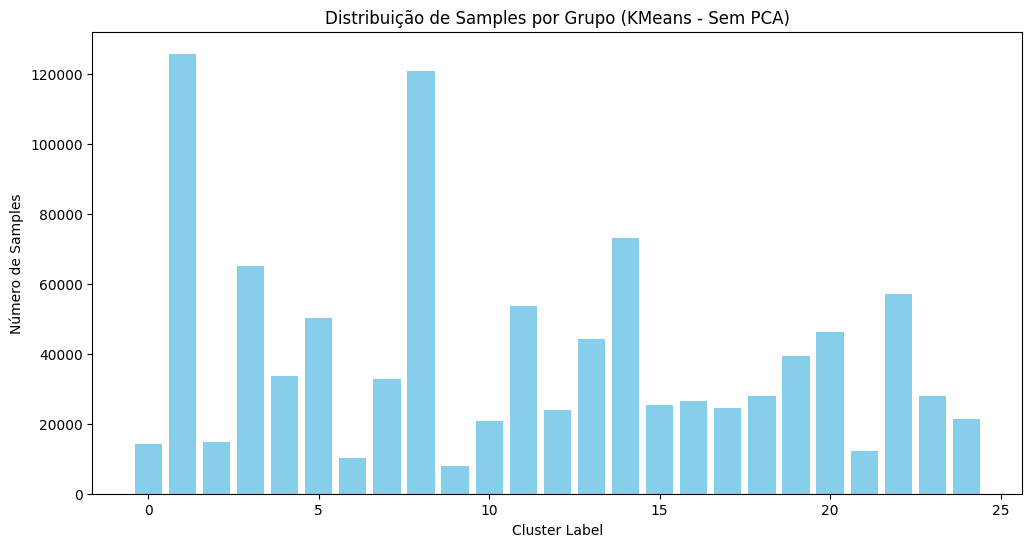

In [62]:
unique_labels, counts = np.unique(kmeans_pca_25_clusters, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
print(f"Total unique labels: {len(unique_labels)}")
print(f"Total samples per Split: {len(ratings_train_pca_df)}")

plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (KMeans - Sem PCA)')
plt.show()

K-means utilizando o PCA mostra uma distribuição de cluster's similar ao K-means sem PCA. ( Máximo de 12 % das amostras em um mesmo cluster)
Vale lembrar que essa comparação é feita com ambos tendo o mesmo número de clusters = 25.

## DBSCAN - com PCA

Usando split do dataSet com PCA em 10 partes de aproximadamente 100.000 linhas.

In [68]:
ratings_pca_df_dict[0]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.604671,-0.450070,-0.957239,-1.701406,-0.082081,0.247301,0.120725,0.187883,-0.270737,-0.808700
1,-1.076852,-0.437329,3.896776,0.216048,0.824245,1.740655,0.699686,-0.568203,0.616493,-0.299663
2,-1.377915,-0.018774,0.490941,-0.339732,-1.726328,-0.574288,-0.357353,1.434195,-0.560377,-0.193797
3,0.216416,-1.697141,-0.775638,0.641605,-0.744340,-0.178341,0.952825,-0.548616,0.313304,0.494465
4,-2.371272,2.014537,0.043904,-1.159178,0.256372,-1.055245,0.788863,0.482717,-0.232405,-0.492209
...,...,...,...,...,...,...,...,...,...,...
100015,0.963171,-0.941329,-1.199252,-0.853911,0.171306,1.425047,1.705268,0.025107,0.362795,-0.675243
100016,0.851340,-0.620851,-0.379713,-0.594911,0.503704,0.813317,-0.233423,0.097202,0.120757,0.334650
100017,0.701809,-0.219957,0.118232,-1.441030,3.193841,0.300948,-0.289786,-1.412090,-0.635252,-0.670330
100018,0.636048,-1.620691,-0.653197,0.050505,-0.603152,0.025727,-0.620410,-0.014725,-0.024698,0.112807


Após teste, foi constatado que o DBSCAN não consegue rodar com o número de dimensões do dataSet montado. Mesmo usando PCA para reduzir a dimensionalidade, o algorítimo usava toda a memória do sistema (32 GB). Sendo assim, o dataSet foi particionado em 10 para rodar o DBSCAN.

Execução com eps = 3 e min_samples = 5 resultou em apenas 5 labels, com mais de 90% dos dados em um grupo. Além disso, usou 30 gb de memória RAM

Execução com eps = 2 e min_samples = 5 resultou em 37 labels. No entanto, ainda há concentração de 80% das amostras em um grupo.

In [69]:
dbscan = DBSCAN(eps=2, min_samples=5, n_jobs=10)
dbscan_eps3_pca_labels = dbscan.fit_predict(ratings_pca_df_dict[0])

Total unique labels: 37
Total samples per Split: 100020


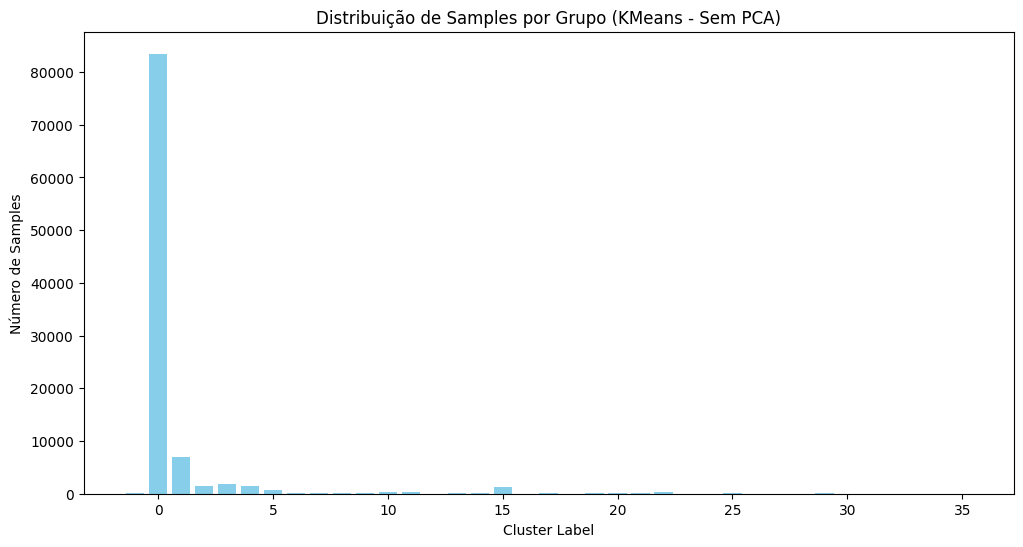

In [70]:
import numpy as np

unique_labels, counts = np.unique(dbscan_eps3_pca_labels, return_counts=True)
print(f"Total unique labels: {len(unique_labels)}")
print(f"Total samples per Split: {len(ratings_pca_df_dict[0])}")

plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (KMeans - Sem PCA)')
plt.show()

Rodando DBSCAN usando PCA com 10 componentes principais (eps = 2 ; min_samples=5) resultou em 37 grupos, sendo que um deles sempre concentrada em torno de 83% das amostras de treino.

Isso mostra uma dificuldade de clusterização usando PCA.

## DBSCAN - Sem PCA

Usando split do dataSet original em 10 partes de aproximadamente 100.000 linhas.

Foi testado essa variação (DBSCAN sem PCA) utilizando eps=2, eps=3 e eps=5. Em todas elas, mais que 80% das amostras se concentram em um grupo

In [38]:
ratings_df_dict[0]

,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,-1.415775,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1,1.269747,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,4.888194,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-2.279046
2,0.374573,0.475069,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,3.40217,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.927070
3,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,0.717975
4,-2.310949,-0.950503,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,2.067157,-0.271205,-0.145311,0.230088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100015,-0.520601,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,-0.188101
100016,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,-0.606290
100017,-0.520601,-0.237717,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,3.477663,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,-1.860857
100018,1.269747,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372


In [ ]:
dbscan = DBSCAN(eps=5, min_samples=5, n_jobs=10)
dbscan_labels = dbscan.fit_predict(ratings_df_dict[0])

Total unique labels: 12
Total samples per Split: 33340


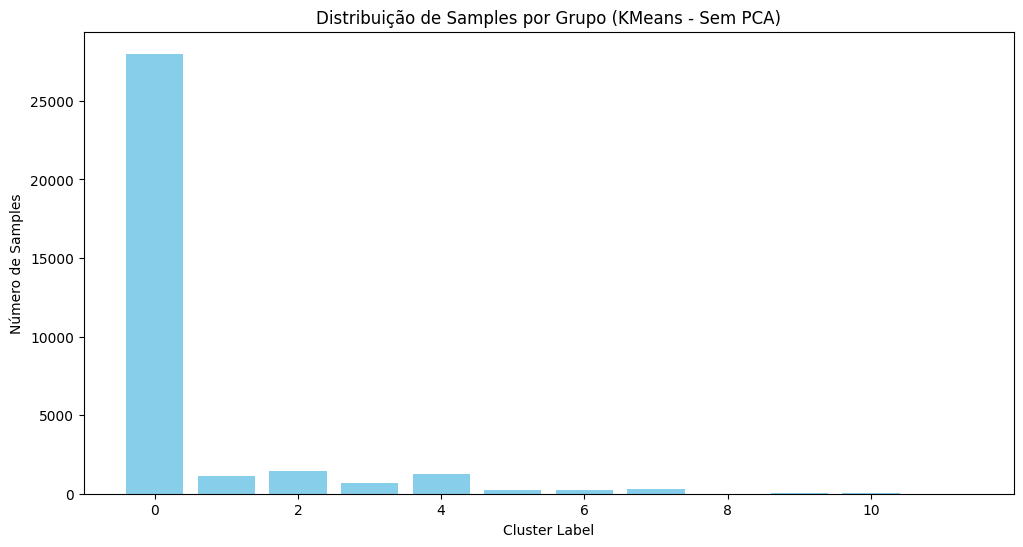

In [ ]:
import numpy as np

unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
print(f"Total unique labels: {len(unique_labels)}")
print(f"Total samples per Split: {len(ratings_df_dict[0])}")
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (KMeans - Sem PCA)')
plt.show()

## Clustering Hierarquico Aglomerativo

### Dados Originais

Por definição, o clustering hierarquico irá utilizar muita memória. Ao testar com o dataSet inteiro, foi solicitado 3.64 TiB de memória (e o kernel deu erro).

Portanto, após testes com splits de 10 e 20 conjuntos, apenas consegui rodar o código em minha máquina utilizando 30 Splits.

In [49]:
# Dividindo ratings_train_df em 'n' amostras aproximadamente iguais
ratings_df_dict2 = {}
ratings_movieid_dict3 = {}
n_splits = 30
split_size = len(ratings_train_df) // n_splits

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(ratings_train_df)
    ratings_df_dict2[i] = ratings_train_df.iloc[start_idx:end_idx].reset_index(drop=True)
    ratings_movieid_dict3[i] = ratings_df_final['MovieID'].iloc[start_idx:end_idx].reset_index(drop=True)


Utilizando o seguinte modelo de DF:

In [ ]:
ratings_df_dict2[0]

,Rating,Review_Date_Period,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Production_Year_Label
0,-1.415775,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,1.343505,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
1,1.269747,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,4.888194,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-2.279046
2,0.374573,0.475069,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,3.40217,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.927070
3,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,2.404167,-0.431981,-0.483756,-0.271205,-0.145311,0.717975
4,-2.310949,-0.950503,1.698516,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,2.067157,-0.271205,-0.145311,0.230088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33335,0.374573,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,2.314919,2.067157,-0.271205,-0.145311,0.787673
33336,1.269747,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.857372
33337,1.269747,0.475069,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,-0.740998,...,-0.13637,-0.287549,-0.208142,4.888194,-0.415944,-0.431981,2.067157,-0.271205,-0.145311,-2.279046
33338,-0.520601,-0.950503,-0.588749,-0.393236,-0.212702,-0.278899,-0.744322,-0.29393,-0.089283,1.349531,...,-0.13637,-0.287549,-0.208142,-0.204575,-0.415944,-0.431981,-0.483756,-0.271205,-0.145311,0.787673


In [50]:
# Clustering Hierárquico Aglomerativo usando o ratings_train_df
agg_cluster = AgglomerativeClustering(n_clusters=25)
agg_labels = agg_cluster.fit_predict(ratings_df_dict2[0])


Total unique labels: 25
Total samples per Split: 33340


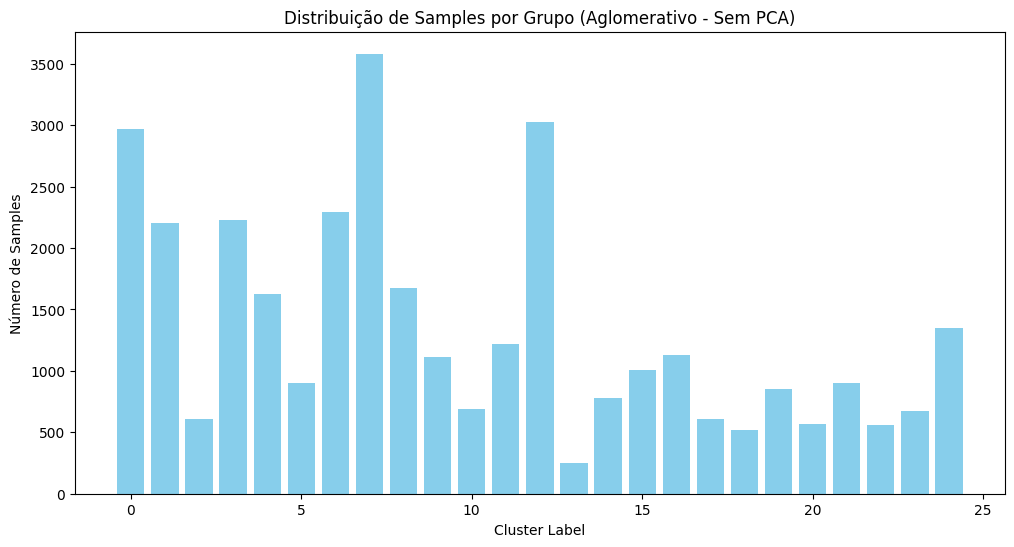

In [51]:
# Plotando a distribuição dos samples por cluster
unique_labels, counts = np.unique(agg_labels, return_counts=True)

print(f"Total unique labels: {len(unique_labels)}")
print(f"Total samples per Split: {len(ratings_df_dict2[0])}")

plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (Aglomerativo - Sem PCA)')
plt.show()

A distribuição de amostras dentre os grupos usando Clustering Hierárquico Aglomerativo parece satisfatório. No entanto, o fato de ter sido necessário dividir os dados originais em 30 dataSets distintos leva à questionar se não há muita perda de dados para representação dos clusters.

### Com PCA

In [53]:
# Dividindo ratings_train_pca_df em 'n' amostras aproximadamente iguais
ratings_df_dict2 = {}
ratings_movieid_dict3 = {}
n_splits = 30
split_size = len(ratings_train_pca_df) // n_splits

for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(ratings_train_pca_df)
    ratings_df_dict2[i] = ratings_train_pca_df.iloc[start_idx:end_idx].reset_index(drop=True)
    ratings_movieid_dict3[i] = ratings_df_final['MovieID'].iloc[start_idx:end_idx].reset_index(drop=True)

Utilizando o seguinte modelo de DF:

In [54]:
ratings_df_dict2[0]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,0.604671,-0.450070,-0.957239,-1.701406,-0.082081,0.247301,0.120725,0.187883,-0.270737,-0.808700
1,-1.076852,-0.437329,3.896776,0.216048,0.824245,1.740655,0.699686,-0.568203,0.616493,-0.299663
2,-1.377915,-0.018774,0.490941,-0.339732,-1.726328,-0.574288,-0.357353,1.434195,-0.560377,-0.193797
3,0.216416,-1.697141,-0.775638,0.641605,-0.744340,-0.178341,0.952825,-0.548616,0.313304,0.494465
4,-2.371272,2.014537,0.043904,-1.159178,0.256372,-1.055245,0.788863,0.482717,-0.232405,-0.492209
...,...,...,...,...,...,...,...,...,...,...
33335,-1.490117,0.838635,0.563266,-0.724308,0.116599,-0.668658,0.025747,0.065434,0.463036,0.412942
33336,0.004493,-1.359191,-0.059695,0.795942,-0.583005,-0.719413,-0.820567,-0.266738,-0.022595,0.169525
33337,-1.044334,-0.485883,3.868720,0.113591,0.750574,1.512876,0.548790,-0.711451,0.746302,1.009143
33338,-0.056347,-1.102933,-0.275175,0.259024,-0.495772,-0.853346,-0.506030,-0.359026,-0.512946,-0.902253


In [55]:
# Clustering Hierárquico Aglomerativo usando o ratings_train_df
agg_cluster = AgglomerativeClustering(n_clusters=25)
agg_labels = agg_cluster.fit_predict(ratings_df_dict2[0])


Total unique labels: 25
Total samples per Split: 33340


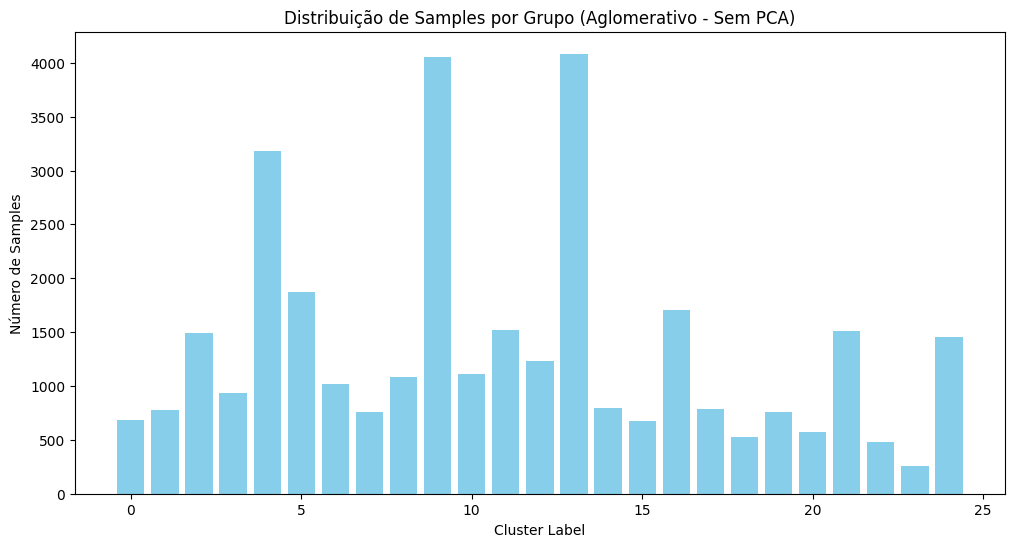

In [56]:
# Plotando a distribuição dos samples por cluster
unique_labels, counts = np.unique(agg_labels, return_counts=True)

print(f"Total unique labels: {len(unique_labels)}")
print(f"Total samples per Split: {len(ratings_df_dict2[0])}")

plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Número de Samples')
plt.title('Distribuição de Samples por Grupo (Aglomerativo - Sem PCA)')
plt.show()

Utilizando PCA resultados similares foram obtidos para o Clustering Hierarquico Aglomerativo, porém mesmo com métade do número de colunas, não houve efeito significativo no desempenho (variação no tempo de execução é em torno de 10 %).

# Análise de Clusters e suas representatividades.

## K-Means sem redução de dimensionalidade

In [64]:
# Para cada cluster, seleciona 5 índices aleatórios (ou menos se não houver 5 amostras)
for cluster_label in np.unique(kmeans_nopca_25_clusters):
    indices_in_cluster = np.where(kmeans_nopca_25_clusters == cluster_label)[0]
    n_samples = min(5, len(indices_in_cluster))
    if n_samples == 0:
        continue
    random_indices = np.random.choice(indices_in_cluster, size=n_samples, replace=False)
    print(f"\nCluster {cluster_label+1}:")
    for idx in random_indices:
        movie_id = ratings_df_final.loc[idx, 'MovieID']
        movie_row = movies_df.set_index('MovieID').loc[movie_id]
        title = movie_row['Title']
        genres = movie_row['Genres']
        print(f"  MovieID: {movie_id} | Title: {title} | Genres: {genres}")


Cluster 1:
  MovieID: 2160 | Title: Rosemary's Baby (1968) | Genres: Horror|Thriller
  MovieID: 2902 | Title: Psycho II (1983) | Genres: Horror|Thriller
  MovieID: 2160 | Title: Rosemary's Baby (1968) | Genres: Horror|Thriller
  MovieID: 2617 | Title: Mummy, The (1999) | Genres: Action|Adventure|Horror|Thriller
  MovieID: 3826 | Title: Hollow Man (2000) | Genres: Horror|Sci-Fi|Thriller

Cluster 2:
  MovieID: 2321 | Title: Pleasantville (1998) | Genres: Comedy
  MovieID: 1080 | Title: Monty Python's Life of Brian (1979) | Genres: Comedy
  MovieID: 3210 | Title: Fast Times at Ridgemont High (1982) | Genres: Comedy
  MovieID: 3740 | Title: Big Trouble in Little China (1986) | Genres: Action|Comedy
  MovieID: 231 | Title: Dumb & Dumber (1994) | Genres: Comedy

Cluster 3:
  MovieID: 2949 | Title: Dr. No (1962) | Genres: Action
  MovieID: 3307 | Title: City Lights (1931) | Genres: Comedy|Drama|Romance
  MovieID: 971 | Title: Cat on a Hot Tin Roof (1958) | Genres: Drama
  MovieID: 2947 | Tit

Separação aproximada dos Clusters:

Cluster 1: Action|Horror|Sci-Fi|Thriller 

Cluster 2: Comedy

Cluster 3: Drama (com presença ocasional de Sci-Fi)

Cluster 4: Ação, Aventura, Sci-Fi, Thriller

Cluster 5: Animação, Infantil, Comédia (e Romance)

Cluster 6: Thriller e Drama

Cluster 7: Fantasia, Aventura, Sci-Fi, Romance

Cluster 8: Drama e Guerra (com Ação ocasional)

Cluster 9: Animação, Infantil, Musical, Fantasia

Cluster 10: Western, comédia, ação, romance, guerra

Cluster 11: Documentário (comédia ocasional)

Cluster 12: Crime, Drama, Ação, Romance

Cluster 13: Mistério, Horror, Thriller

Cluster 14: Film-Noir, Crime, Mistério, Aventura

Cluster 15: Horror (comédia e Sci-Fi ocasionais)

Cluster 16: Drama e Romance

Cluster 17: Infantil, Fantasia, Comédia, Aventura, Sci-Fi

Cluster 18: Musical, Comédia

Cluster 19: Comédia, Drama, Thriller

Cluster 20: Infantil, Comédia

Cluster 21: Ação, Aventura, Comédia, Romance

Cluster 22: Ação, Sci-Fi, Aventura

Cluster 23: Comédia, Romance

Cluster 24: Guerra, Sci-Fi, Ação, Aventura, Thriller, Romance

Também é possível visualizar se há segregação de notas dadas por clustering ( o que não é um objetivo central ).

Observa-se que a média fica em torno de -0.5 à 0.5 (normalizado), o que mostra que esse tipo de agrupamento não acontece.

In [74]:
# Adiciona os rótulos dos clusters ao DataFrame de treino
ratings_df_final['Cluster'] = kmeans_nopca_25_clusters

# Calcula estatísticas de rating por cluster
cluster_rating_stats = ratings_df_final.groupby('Cluster')['Rating'].agg(['count', 'mean', 'std', 'min', 'max'])
cluster_rating_stats.rename(columns={'count': 'Num Ratings', 'mean': 'Mean Rating', 'std': 'Std Rating', 'min': 'Min Rating', 'max': 'Max Rating'}, inplace=True)

# Exibe as estatísticas
cluster_rating_stats

,Num Ratings,Mean Rating,Std Rating,Min Rating,Max Rating
Cluster,,,,,
0,17409,-0.263449,1.099638,-2.310949,1.269747
1,120829,-0.131553,1.024424,-2.310949,1.269747
2,33343,0.480593,0.792457,-2.310949,1.269747
3,150001,0.115809,0.937848,-2.310949,1.269747
4,30723,-0.146716,1.035446,-2.310949,1.269747
5,23936,0.151377,0.982047,-2.310949,1.269747
6,67069,-0.032926,0.955129,-2.310949,1.269747
7,20900,-0.029755,0.991915,-2.310949,1.269747
8,47911,0.292176,0.943319,-2.310949,1.269747


## K-Means com PCA

In [66]:
# Para cada cluster, seleciona 5 índices aleatórios (ou menos se não houver 5 amostras)
for cluster_label in np.unique(kmeans_pca_25_clusters):
    indices_in_cluster = np.where(kmeans_pca_25_clusters == cluster_label)[0]
    n_samples = min(5, len(indices_in_cluster))
    if n_samples == 0:
        continue
    random_indices = np.random.choice(indices_in_cluster, size=n_samples, replace=False)
    print(f"\nCluster {cluster_label+1}:")
    for idx in random_indices:
        movie_id = ratings_df_final.loc[idx, 'MovieID']
        movie_row = movies_df.set_index('MovieID').loc[movie_id]
        title = movie_row['Title']
        genres = movie_row['Genres']
        print(f"  MovieID: {movie_id} | Title: {title} | Genres: {genres}")


Cluster 1:
  MovieID: 2122 | Title: Children of the Corn (1984) | Genres: Horror|Thriller
  MovieID: 3535 | Title: American Psycho (2000) | Genres: Comedy|Horror|Thriller
  MovieID: 3664 | Title: Puppet Master 5: The Final Chapter (1994) | Genres: Horror|Sci-Fi|Thriller
  MovieID: 1994 | Title: Poltergeist (1982) | Genres: Horror|Thriller
  MovieID: 2550 | Title: Haunting, The (1963) | Genres: Horror|Thriller

Cluster 2:
  MovieID: 1449 | Title: Waiting for Guffman (1996) | Genres: Comedy
  MovieID: 104 | Title: Happy Gilmore (1996) | Genres: Comedy
  MovieID: 1285 | Title: Heathers (1989) | Genres: Comedy
  MovieID: 3263 | Title: White Men Can't Jump (1992) | Genres: Comedy
  MovieID: 2395 | Title: Rushmore (1998) | Genres: Comedy

Cluster 3:
  MovieID: 595 | Title: Beauty and the Beast (1991) | Genres: Animation|Children's|Musical
  MovieID: 2099 | Title: Song of the South (1946) | Genres: Adventure|Animation|Children's|Musical
  MovieID: 2087 | Title: Peter Pan (1953) | Genres: Ani

Separação aproximada dos Clusters:

Cluster 1: Horror-Thriller com elementos de Sci-Fi

Cluster 2: Comédia

Cluster 3: Drama clássico com elementos de Ação e Romance

Cluster 4: Ação, Aventura, Sci-Fi e Thriller

Cluster 5: Crime, Drama e Thriller

Cluster 6: Guerra com Drama e Ação

Cluster 7: Fantasia, Aventura e Sci-Fi

Cluster 8: Mistério, Sci-Fi e Thriller

Cluster 9: Drama sério e focado em personagens

Cluster 10: Documentário

Cluster 11: Faroeste

Cluster 12: Comédia Romântica

Cluster 13: Animação, Infantil e Comédia

Cluster 14: Drama Romântico

Cluster 15: Ação, Aventura e Sci-Fi

Cluster 16: Infantil, Aventura e Comédia

Cluster 17: Musical com Romance e Comédia

Cluster 18: Fantasia com Comédia e Romance

Cluster 19: Drama com elementos de Comédia

Cluster 20: Terror tradicional

Cluster 21: Comédia e Drama equilibrados

Cluster 22: Film-Noir, Mistério e Thriller

Cluster 23: Thriller psicológico e dramático

Cluster 24: Ação, Crime e Thriller

Cluster 25: Horror com Sci-Fi e Ação

## DBSCAN com PCA

A clusterização utilizando DBSCAN não se mostrou funcional (Cluster 0 contém 80% das amostras).

Nessa visualização é possível ver que alguns cluster's absorveram filmes específicos, enquantos outros observeram filmes variados.

In [ ]:
# Para cada cluster, seleciona 5 índices aleatórios (ou menos se não houver 5 amostras)
for cluster_label in np.unique(dbscan_eps3_pca_labels):
    indices_in_cluster = np.where(dbscan_eps3_pca_labels == cluster_label)[0]
    n_samples = min(5, len(indices_in_cluster))
    if n_samples == 0:
        continue
    random_indices = np.random.choice(indices_in_cluster, size=n_samples, replace=False)
    print(f"\nCluster {cluster_label+1}:")
    for idx in random_indices:
        movie_id = ratings_df_final.loc[idx, 'MovieID']
        movie_row = movies_df.set_index('MovieID').loc[movie_id]
        title = movie_row['Title']
        genres = movie_row['Genres']
        print(f"  MovieID: {movie_id} | Title: {title} | Genres: {genres}")


Cluster 0:
  MovieID: 239 | Title: Goofy Movie, A (1995) | Genres: Animation|Children's|Comedy|Romance
  MovieID: 3273 | Title: Scream 3 (2000) | Genres: Horror|Mystery|Thriller
  MovieID: 913 | Title: Maltese Falcon, The (1941) | Genres: Film-Noir|Mystery
  MovieID: 673 | Title: Space Jam (1996) | Genres: Adventure|Animation|Children's|Comedy|Fantasy
  MovieID: 3920 | Title: Faraway, So Close (In Weiter Ferne, So Nah!) (1993) | Genres: Drama|Fantasy

Cluster 1:
  MovieID: 3688 | Title: Porky's (1981) | Genres: Comedy
  MovieID: 1961 | Title: Rain Man (1988) | Genres: Drama
  MovieID: 110 | Title: Braveheart (1995) | Genres: Action|Drama|War
  MovieID: 1753 | Title: Half Baked (1998) | Genres: Comedy
  MovieID: 2615 | Title: My Science Project (1985) | Genres: Adventure|Sci-Fi

Cluster 2:
  MovieID: 3549 | Title: Guys and Dolls (1955) | Genres: Musical
  MovieID: 1288 | Title: This Is Spinal Tap (1984) | Genres: Comedy|Drama|Musical
  MovieID: 2300 | Title: Producers, The (1968) | Gen

## Clustering Hierarquico Aglomerativo - S/ PCA